# How well does oil supply, aggregate demand and oil price predict Danish stock prices?

Imports and set magics:

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
from pathlib import Path  
import datetime as dt
from pandas.tseries.offsets import MonthBegin
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, Dropdown



# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
from dataproject import lin_reg


### Data description

In this project I will work with 5 different data sets imported manually from different sources. The data sets are:
1. US_CPI downloaded from the U.S. Bureau of Labor Statistics
2. The global production in world crude oil, initially downloaded through an API, but uploaded as a .csv for this project. The data is from The U.S. Energy Information Administration.
3. The Baltic Dry Exchange index, downloaded from Investing.com.
4. The price of crude oil, downloaded from The U.S. Energy Information Administration.
5. The OMXC20 Index downloaded from Investing.com.


The data that I work with in this project, is the same data that I am working with for my masters project.
The US CPI is the seasonally unadjusted US city average CPI with base years 1982-1984. The global production in crude oil is the total production in crude oil for all oil producing countries in the world. The Baltic Dry Exchange Index is an index describing the freight rates of over 20 major shipping routes in the world - this will be used as a proxy for aggregate demand, as higher demand worldwide leads to higher shipping rates. The price of crude oil is the US refiner's acquisition cost for import of crude oil. The OMXC20 index is a stock index covering the 20 most traded stocks on the Danish stock market. All data is in monthly observations.


### Data import
I have supplied the 5 different data sets as .csv files. In the data import section I will load them, and illustrate the raw structure in pandas dataframes.



In [2]:
CPI = pd.read_csv("CPI.csv")
print('Raw structure of CPI:')
display(CPI.head(3))

oil_prod = pd.read_csv("crude_oil_prod.csv")
print('Raw structure of oil production:')
display(oil_prod.head(3))

BDI = pd.read_csv("BDI.csv")
print('Raw structure of Baltic Dry Index:')
display(BDI.head(3))

oil_price = pd.read_csv("crude_oil_price.csv")
print('Raw structure of oil price:')
display(oil_price.head(3))

C20 = pd.read_csv("OMX Copenhagen 20 Historical Data.csv")
print('Raw structure of OMXC20 index:')
display(C20.head(3))

Raw structure of CPI:


,Unnamed: 0,Year,Period,Label,Observation Value,1-Month Net Change,12-Month Net Change,1-Month % Change,12-Month % Change
0,0,1970,M01,1970 Jan,37.8,NaN,NaN,0.3,6.2
1,1,1970,M02,1970 Feb,38.0,NaN,NaN,0.5,6.1
2,2,1970,M03,1970 Mar,38.2,NaN,NaN,0.5,5.8


Raw structure of oil production:


,Unnamed: 0,Column1.period,Column1.productId,Column1.productName,Column1.activityId,Column1.activityName,Column1.countryRegionId,Column1.countryRegionName,Column1.countryRegionTypeId,Column1.countryRegionTypeName,Column1.unit,Column1.unitName,Column1.dataFlagId,Column1.dataFlagDescription,Column1.value
0,0,2022-09,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,TBPD,thousand barrels per day,NaN,NaN,81654.365452
1,1,2022-08,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,TBPD,thousand barrels per day,NaN,NaN,81340.371683
2,2,2022-07,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,TBPD,thousand barrels per day,NaN,NaN,80311.163563


Raw structure of Baltic Dry Index:


,Unnamed: 0,Date,Price,Open,High,Low,Vol.,Change %
0,0,01/01/2023,721.00,"1,250.00","1,250.00","1,250.00",NaN,-52.41%
1,1,12/01/2022,"1,515.00","1,338.00","1,338.00","1,338.00",NaN,11.81%
2,2,11/01/2022,"1,355.00","1,377.00","1,377.00","1,377.00",NaN,-7.38%


Raw structure of oil price:


,Unnamed: 0,Date,U.S. Crude Oil Composite Acquisition Cost by Refiners (Dollars per Barrel),U.S. Crude Oil Domestic Acquisition Cost by Refiners (Dollars per Barrel),U.S. Crude Oil Imported Acquisition Cost by Refiners (Dollars per Barrel)
0,0,1974-01-15,7.46,6.72,9.59
1,1,1974-02-15,8.57,7.08,12.45
2,2,1974-03-15,8.68,7.05,12.73


Raw structure of OMXC20 index:


,Date,Price,Open,High,Low,Vol.,Change %
0,02/01/2023,"1,911.74","1,847.91","1,928.59","1,826.14",14.35M,4.21%
1,01/01/2023,"1,834.53","1,842.37","1,901.34","1,806.33",261.23M,-0.04%
2,12/01/2022,"1,835.28","1,797.98","1,862.04","1,787.18",213.44M,2.83%


### Data cleaning
Having discovered the raw structure of the 5 datasets, I will now clean the data. I will drop all the columns not needed, I will make sure that the date structure is the same for all variables. Furthermore, I will rename column names and remove comma-thousand seperators.



In [3]:
#CPI Cleaning:
CPI_clean = CPI.copy()
CPI_clean["Label"]=pd.to_datetime(CPI_clean["Label"])
CPI_clean.drop(CPI_clean.iloc[:,[0,1,2,5,6,7,8]], axis=1, inplace=True)
CPI_clean.rename(columns = {"Label":"Date", "Observation Value":"CPI"}, inplace=True)

#Oil production cleaning:
oil_prod_clean = oil_prod.copy()
oil_prod_clean.drop(oil_prod_clean.iloc[:,[0,2,3,4,5,6,7,8,9,10,11,12,13]], axis=1, inplace=True)
oil_prod_clean['Column1.period'] = pd.to_datetime(oil_prod_clean['Column1.period'])
oil_prod_clean.rename(columns= {"Column1.period":"Date", "Column1.value" :"oil_prod"}, inplace=True)
oil_prod_clean=oil_prod_clean.loc[::-1].reset_index(drop=True)

#Baltic Dry Index cleaning:
BDI_clean = BDI.copy()
BDI_clean.drop(BDI_clean.iloc[:,[0,3,4,5,6,7]], axis=1, inplace=True)
BDI_clean['Price']=BDI_clean['Price'].str.replace(',','').astype(float)
BDI_clean.rename(columns= {"Price" : "BDI_price"}, inplace=True)
BDI_clean['Date']=pd.to_datetime(BDI_clean['Date'])
BDI_clean=BDI_clean.loc[::-1].reset_index(drop=True)

#Oil price cleaning:
oil_price_clean = oil_price.copy()
oil_price_clean['Date'] = pd.to_datetime(oil_price_clean['Date']) - MonthBegin(1)
oil_price_clean.drop(oil_price_clean.iloc[:,[0,2,3]], axis=1, inplace=True)
oil_price_clean.rename(columns= {"U.S. Crude Oil Imported Acquisition Cost by Refiners (Dollars per Barrel)" : "oil_price"}, inplace=True)

#C20 index cleaning:
C20_clean = C20.copy()
C20_clean.drop(C20_clean.iloc[:,2:7], axis=1, inplace=True)
C20_clean['Price']=C20_clean['Price'].str.replace(',','').astype(float)
C20_clean.rename(columns= {"Price" : "C20_price"}, inplace=True)
C20_clean['Date']=pd.to_datetime(C20_clean['Date'])
C20_clean=C20_clean.loc[::-1].reset_index(drop=True)


#Illustrating cleaned data sets:
print('Clean CPI:')
display(CPI_clean.head(3))

print('Clean oil production:')
display(oil_prod_clean.head(3))

print('Clean Baltic Dry Index:')
display(BDI_clean.head(3))

print('Clean oil price:')
display(oil_price_clean.head(3))

print('Clean OMXC20 index:')
display(C20_clean.head(3))


Clean CPI:


,Date,CPI
0,1970-01-01,37.8
1,1970-02-01,38.0
2,1970-03-01,38.2


Clean oil production:


,Date,oil_prod
0,1973-01-01,54389.0
1,1973-02-01,54930.0
2,1973-03-01,54995.0


Clean Baltic Dry Index:


,Date,BDI_price
0,1985-02-01,984.0
1,1985-03-01,1016.5
2,1985-04-01,1063.0


Clean oil price:


,Date,oil_price
0,1974-01-01,9.59
1,1974-02-01,12.45
2,1974-03-01,12.73


Clean OMXC20 index:


,Date,C20_price
0,1990-01-01,106.51
1,1990-02-01,105.94
2,1990-03-01,111.34


### Data exploration
In this section I will show plots of the raw data for each of the 5 variables.


Plots of the raw variables:


Text(0.5, 1.0, 'C20 price')

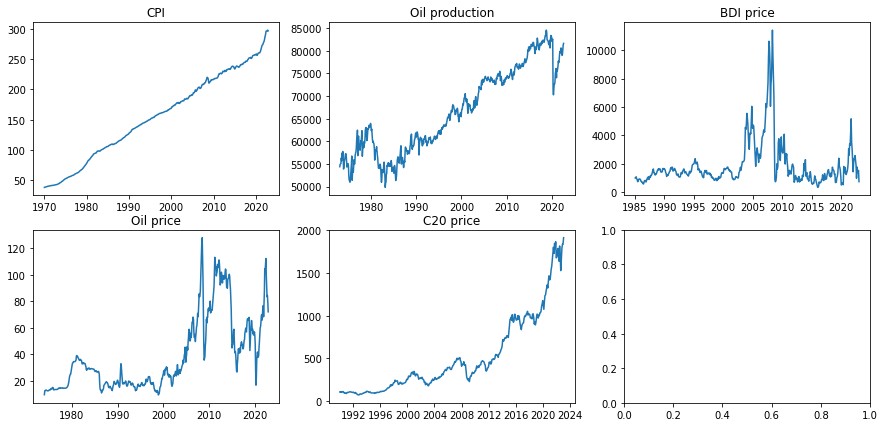

In [4]:
print("Plots of the raw variables:")
fig_raw, axs = plt.subplots(2,3, figsize=(15,7))
axs[0,0].plot(CPI_clean['Date'], CPI_clean['CPI'])
axs[0, 0].set_title('CPI')
axs[0,1].plot(oil_prod_clean['Date'], oil_prod_clean['oil_prod'])
axs[0, 1].set_title('Oil production')
axs[0,2].plot(BDI_clean['Date'], BDI_clean['BDI_price'])
axs[0, 2].set_title('BDI price')
axs[1,0].plot(oil_price_clean['Date'], oil_price_clean['oil_price'])
axs[1, 0].set_title('Oil price')
axs[1,1].plot(C20_clean['Date'], C20_clean['C20_price'])
axs[1, 1].set_title('C20 price')

Looking at the plots, it is obvious that the date ranges are not the same. Furthermore, none of the variables seem stationary.

### Data merging
In this section I will merge the 5 datasets into 1 dataframe, and drop all NaN values, such that the date range is limited to dates where all of the 5 datasets have observations.
I will do this by outer joining all of the datasets on the Date column, and then dropping missing observations. I will also supply descriptive stats.

In [5]:
merged = CPI_clean.merge(oil_prod_clean, on='Date', how='outer')
merged = merged.merge(BDI_clean, on='Date', how='outer')
merged = merged.merge(oil_price_clean, on='Date', how='outer')
merged = merged.merge(C20_clean, on='Date', how='outer')
merged.dropna(inplace=True)
print("Merged data:")
display(merged.head(3))

#Descriptive stats:
print("Descriptive stats:")
display(merged.describe().round(2))

Merged data:


,Date,CPI,oil_prod,BDI_price,oil_price,C20_price
240,1990-01-01,127.4,60921.388,1644.0,20.51,106.51
241,1990-02-01,128.0,61178.881,1604.0,19.78,105.94
242,1990-03-01,128.7,62082.423,1529.0,18.94,111.34


Descriptive stats:


,CPI,oil_prod,BDI_price,oil_price,C20_price
count,393.00,393.00,393.00,393.00,393.00
mean,200.14,71598.91,1998.21,46.87,493.23
std,42.43,7227.93,1708.87,29.96,428.85
min,127.40,56965.63,317.00,9.39,71.72
25%,162.20,65949.50,1070.00,19.35,192.07
50%,201.50,73204.54,1438.00,39.89,335.03
75%,236.15,76974.86,2102.00,66.70,737.23
max,296.81,84585.02,11440.00,127.77,1863.99


### Data transformations
Having merged the datasets i can start transforming. It is clear from the visual inspections and descriptive stats, the the variables are not stationary, with high variances. I want to have the real price of the BDI, oil and C20. I will use the CPI to divide through these and times by 100. Furthermore, I want the percentage changes of all the variables, and I will get these by taking the log-differences and time them by 100 to get them in %. By taking the log-difference of the real C20 price, we will get the real returns on the C20 stock index, which is the variable we want to explain by the other variables.

In [6]:
merged_transformed = merged.copy()
#Oil prod transformation:
merged_transformed.insert(loc=6, column="oil_prod_pct_change", value=(np.log(merged_transformed["oil_prod"])-np.log(merged_transformed["oil_prod"]).shift(1))*100)
#BDI transformation:
merged_transformed.insert(loc=7, column="real_BDI_price_pct_change", value=(np.log(merged_transformed["BDI_price"]/merged_transformed["CPI"]*100) - np.log(merged_transformed["BDI_price"]/merged_transformed["CPI"]*100).shift(1))*100)
#Oil price transformation:
merged_transformed.insert(loc=8, column="real_oil_price_pct_change", value=(np.log(merged_transformed["oil_price"]/merged_transformed["CPI"]*100) - np.log(merged_transformed["oil_price"]/merged_transformed["CPI"]*100).shift(1))*100)
#C20 transformation:
merged_transformed.insert(loc=9, column="real_C20_returns", value=(np.log(merged_transformed["C20_price"]/merged_transformed["CPI"]*100) - np.log(merged_transformed["C20_price"]/merged_transformed["CPI"]*100).shift(1))*100)

#Dropping raw variables, and keeping the four transformed variables:
merged_transformed.drop(merged_transformed.iloc[:,1:6], axis=1, inplace=True)
merged_transformed.dropna(inplace=True)

#Illustrating transformed data:
print("Transformed data:")
display(merged_transformed.head(3))

Transformed data:


,Date,oil_prod_pct_change,real_BDI_price_pct_change,real_oil_price_pct_change,real_C20_returns
241,1990-02-01,0.421774,-2.933031,-4.093977,-1.006450
242,1990-03-01,1.466086,-5.334043,-4.884909,4.426184
243,1990-04-01,-0.446354,-11.794700,-12.981825,-9.083662


### I will now vizualise the transformed data


Plots of the transformed variables:


Text(0.5, 1.0, 'Real returns of the C20 index')

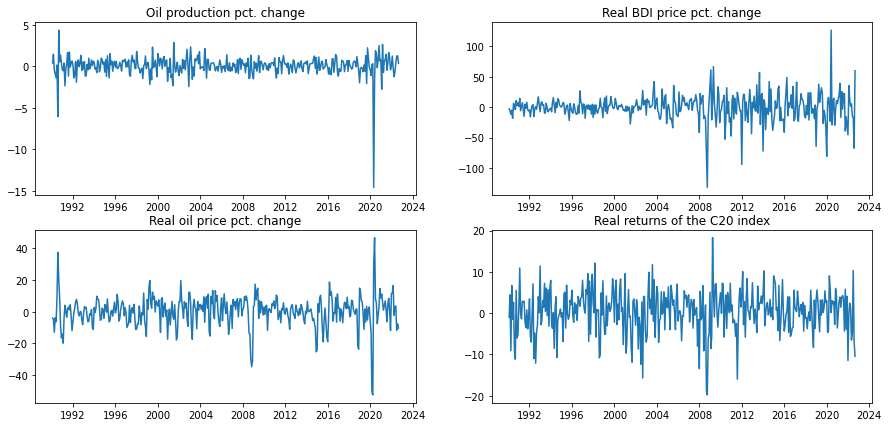

In [7]:
print("Plots of the transformed variables:")
fig_transformed, axs = plt.subplots(2,2, figsize=(15,7))
axs[0,0].plot(merged_transformed['Date'], merged_transformed['oil_prod_pct_change'])
axs[0, 0].set_title('Oil production pct. change')
axs[0,1].plot(merged_transformed['Date'], merged_transformed['real_BDI_price_pct_change'])
axs[0, 1].set_title('Real BDI price pct. change')
axs[1,0].plot(merged_transformed['Date'], merged_transformed['real_oil_price_pct_change'])
axs[1, 0].set_title('Real oil price pct. change')
axs[1,1].plot(merged_transformed['Date'], merged_transformed['real_C20_returns'])
axs[1, 1].set_title('Real returns of the C20 index')


The variables now look close to stationary, but with outliers and changing variance for some of them. We assume stationarity for all of them.

## Empirical analysis
In this section we will analyze if the danish stock returns can be explained by the oil production, oil price and aggregate demand (proxied by the BDI) variables. We will do this by making a simple linear regression with the real stock returns as the dependent variable, and the change in oil production, real change in BDI price and real change in oil price as the independent variables in each their equation.

The linear regression has the form:

$C20_t = \alpha + \beta_1 y_t + + \epsilon_t$

Where $\alpha$ is a constant, $\beta_1$ are coefficients and $\epsilon_t$ are the residuals. The variable names refers to the transformed versions.

We will make 3 regressions, such that there are 1 independent variable in each, and then compare how they seem to fit the real C20 returns.

Then we will plot the original data points of the real returns on the C20, and make an interactive scatter plot that shows the predicted values of the real returns of the C20 from each regression.



In [8]:
#Creating the 3 regressions using the user defined function lin_reg.
y = merged_transformed['real_C20_returns']
T = np.linspace(1,len(y),len(y))

#C20 explained by oil production percentage change:
x1 = merged_transformed['oil_prod_pct_change']
alpha1, beta1, y_hat1 =lin_reg(x1, y)

#C20 explained by real BDI percentage change:
x2 = merged_transformed['real_BDI_price_pct_change']
alpha2, beta2, y_hat2 =lin_reg(x2, y)

#C20 explained by real oil price percentage change:
x3 = merged_transformed['real_oil_price_pct_change']
alpha3, beta3, y_hat3 =lin_reg(x3, y)



Choose which regression to show:


Dropdown(description='Select Plot:', layout=Layout(width='300px'), options=(('Real C20 Returns', 1), ('Real C2…

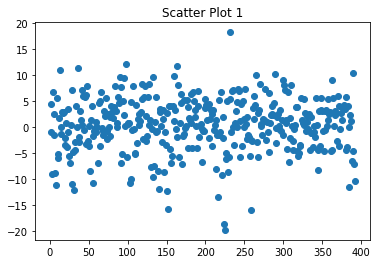

In [9]:


# Define the scatter plot function
def plot_data(data_index):
    plt.clf()  # Clear the previous plot
    plt.scatter(T, y)  # Always plot scatter plot 1
    if data_index == 2:
        plt.scatter(T, y_hat1)
    elif data_index == 3:
        plt.scatter(T, y_hat2)
    elif data_index == 4:
        plt.scatter(T, y_hat3)
    plt.title(f'Scatter Plot {data_index}')

# Create the interactive dropdown widget
dropdown = Dropdown(options=[('Real C20 Returns', 1), ('Real C20 returns predicted from oil production change', 2), 
                             ('Real C20 returns predicted from real BDI price change', 3), ('Real C20 returns predicted from real oil price change', 4)],
                    value=1,
                    description='Select Plot:',
                    layout={'width': '300px'})

# Define the update function for the dropdown
def update_plot(change):
    plot_data(change.new)

# Link the dropdown to the update function
dropdown.observe(update_plot, names='value')

# Plot the initial scatter plot
plot_data(dropdown.value)
print("Choose which regression to show:")

# Display the plot and the dropdown widget
display(dropdown)
plt.show()




# Conclusion

I originally wanted to make a linear regression with multiple independent variables. However, as i was unsure whether we could install packages for this purpose, i decided to create my own linear regression function, but only with 1 independent variable.

The conclusion is that none of the regressions seem to explain the real returns on the C20 index closely. The real price of the BDI index, seems to catch a marginally higher percentage of the variance, but nothing satisfying. If we were to have a linear regression including all the 3 independent variables, the percent of explained variance of the real returns on C20 index, would most likely be higher. 

The plots are very similar. A possible solution could be not to take the log-differences of any of the variables, and then doing the same analysis. This would have resulted in more linear graphs, and the resulting prediction from the linear regressions would have been more comparable.